## Análisis

En este notebook vamos a hacer un análisis de las distintas competiciones (las cinco grandes ligas durante la temporada 2015-2016) y de todos los partidos en general para poder entender que características son más importantes a la hora de tomar la decisión por parte del modelo de ML para decidir si el equipo va a ganar, perder o empatar el partido.

In [8]:
import shap
import pandas as pd
import numpy as np

### La Liga temporada 2015/2016 (masculina)

Cargamos los datos de los partidos sobre La Liga en la temporada 2015/2016 masculina para entrenar el modelo y poder hacer el estudio de explicabilidad.

In [9]:
import os


competition_name = "La Liga"
competition_gender = "male"
season_name_for_filename = "2015_2016"

output_dir = "data/reduced/"
filename = f"{competition_name}({season_name_for_filename}_{competition_gender})_reduced.csv"
output_path = os.path.join(output_dir, filename)

if os.path.exists(output_path):
    print(f"Matches from the competition loaded from {output_path}")
    matches_in_LaLiga = pd.read_csv(output_path)
else:
    print("You don't have data from the competition yet. Please run the notebook '0_datasets_building.ipynb' first.")

Matches from the competition loaded from data/reduced/La Liga(2015_2016_male)_reduced.csv


In [10]:
matches_in_LaLiga.head(5)

,shots_on_target_ratio_home,shots_on_target_ratio_away,average_shots_on_target_distance_home,average_shots_on_target_distance_away,shots_inside_area_ratio_home,shots_inside_area_ratio_away,pass_success_ratio_home,pass_success_ratio_away,cross_success_ratio_home,cross_success_ratio_away,...,percentage_shots_under_pressure_home,percentage_shots_inside_area_under_pressure_home,percentage_passes_under_pressure_home,percentage_passes_inside_area_under_pressure_home,percentage_set_piece_shots_home,percentage_set_piece_shots_inside_area_home,percentage_substitutions_home,percentage_tactical_substitutions_home,percentage_tactical_changes_home,percentage_formation_changes_home
0,0.400000,0.153846,20.462904,15.923442,0.600000,0.384615,0.630915,0.804089,0.000000,0.000000,...,0.500000,1.000000,0.364780,0.000000,0.214286,0.285714,0.5,0.40,1.000000,0.5
1,0.312500,0.300000,25.239973,18.652679,0.187500,0.600000,0.759191,0.690647,0.285714,0.263158,...,0.666667,0.000000,0.476190,0.333333,0.470588,0.000000,0.5,0.50,1.000000,1.0
2,0.333333,0.400000,33.431447,11.773407,0.500000,0.700000,0.609065,0.809783,0.125000,0.222222,...,0.166667,0.250000,0.196491,0.400000,0.333333,0.250000,0.5,0.75,0.666667,0.5
3,0.461538,0.400000,24.394269,9.439840,0.538462,0.800000,0.760377,0.676543,0.125000,0.285714,...,0.500000,0.666667,0.582857,1.000000,0.600000,0.444444,0.5,0.60,0.500000,0.5
4,0.153846,0.200000,20.432657,19.849825,0.384615,0.800000,0.775176,0.700581,0.416667,0.272727,...,0.500000,0.000000,0.555556,0.750000,0.615385,0.384615,0.5,0.50,0.600000,0.5


Una vez ya tenemos los datos cargados, entrenamos el mejor modelo y mostramos sus resultados.

In [11]:
from src.analysis import laliga_best_model


best_model_LaLiga, evaluation_metrics, X_train_reduced_LaLiga, X_test_reduced_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga = laliga_best_model(matches_in_LaLiga)
print(f"The best model for La Liga is {best_model_LaLiga}")
print(f"The evaluation metrics for the best model are:")
evaluation_metrics.head()

The best model for La Liga is LogisticRegression(C=0.29354310869235306, max_iter=1000, penalty='l1',
                   random_state=42, solver='saga')
The evaluation metrics for the best model are:


,Train Accuracy,Test Accuracy,Precision Macro,Precision Weighted,Recall Macro,Recall Weighted,F1 Macro,F1 Weighted
Logistic Regression MI,0.766447,0.723684,0.702033,0.717442,0.684041,0.723684,0.690678,0.718346


Una vez ya tenemos el mejor modelo entrenado comenzamos el análisis de explicabilidad. Vamos a comenzar por un estudio global. 

En este caso, al ser el mejor modelo Logistic Regression, vamos a fijarnos en el coeficiente (método coef_) que nos aporta el modelo para cada característica en cada clase. 
- Con esto, estamos observando la importancia global de cada característica para cada clase en términos de una relación lineal. Es decir, estamos observando relaciones exclusivamente lineales entre las características y la predicción.
- Con esto, no se tiene en cuenta las interacciones entre características ni tampoco explica predicciones individuales.

Los gráficos que se aparecen a continuación muestran la importancia de cada característica para predecir una determinada clase de resultado en los partidos de LaLiga. Las clases son:
- Clase "away_team": Indica qué características influyen en que el equipo visitante gane el partido.
- Clase "draw": Indica qué características influyen en que el partido termine en empate.
- Clase "home_team": Indica qué características influyen en que el equipo local gane el partido.
Los valores representados en el eje X son los coeficientes de la regresión logística, que indican la magnitud e impacto de cada variable en la probabilidad de un resultado específico. Valores positivos aumentan la probabilidad de que ocurra esa clase, mientras que valores negativos disminuyen dicha probabilidad.

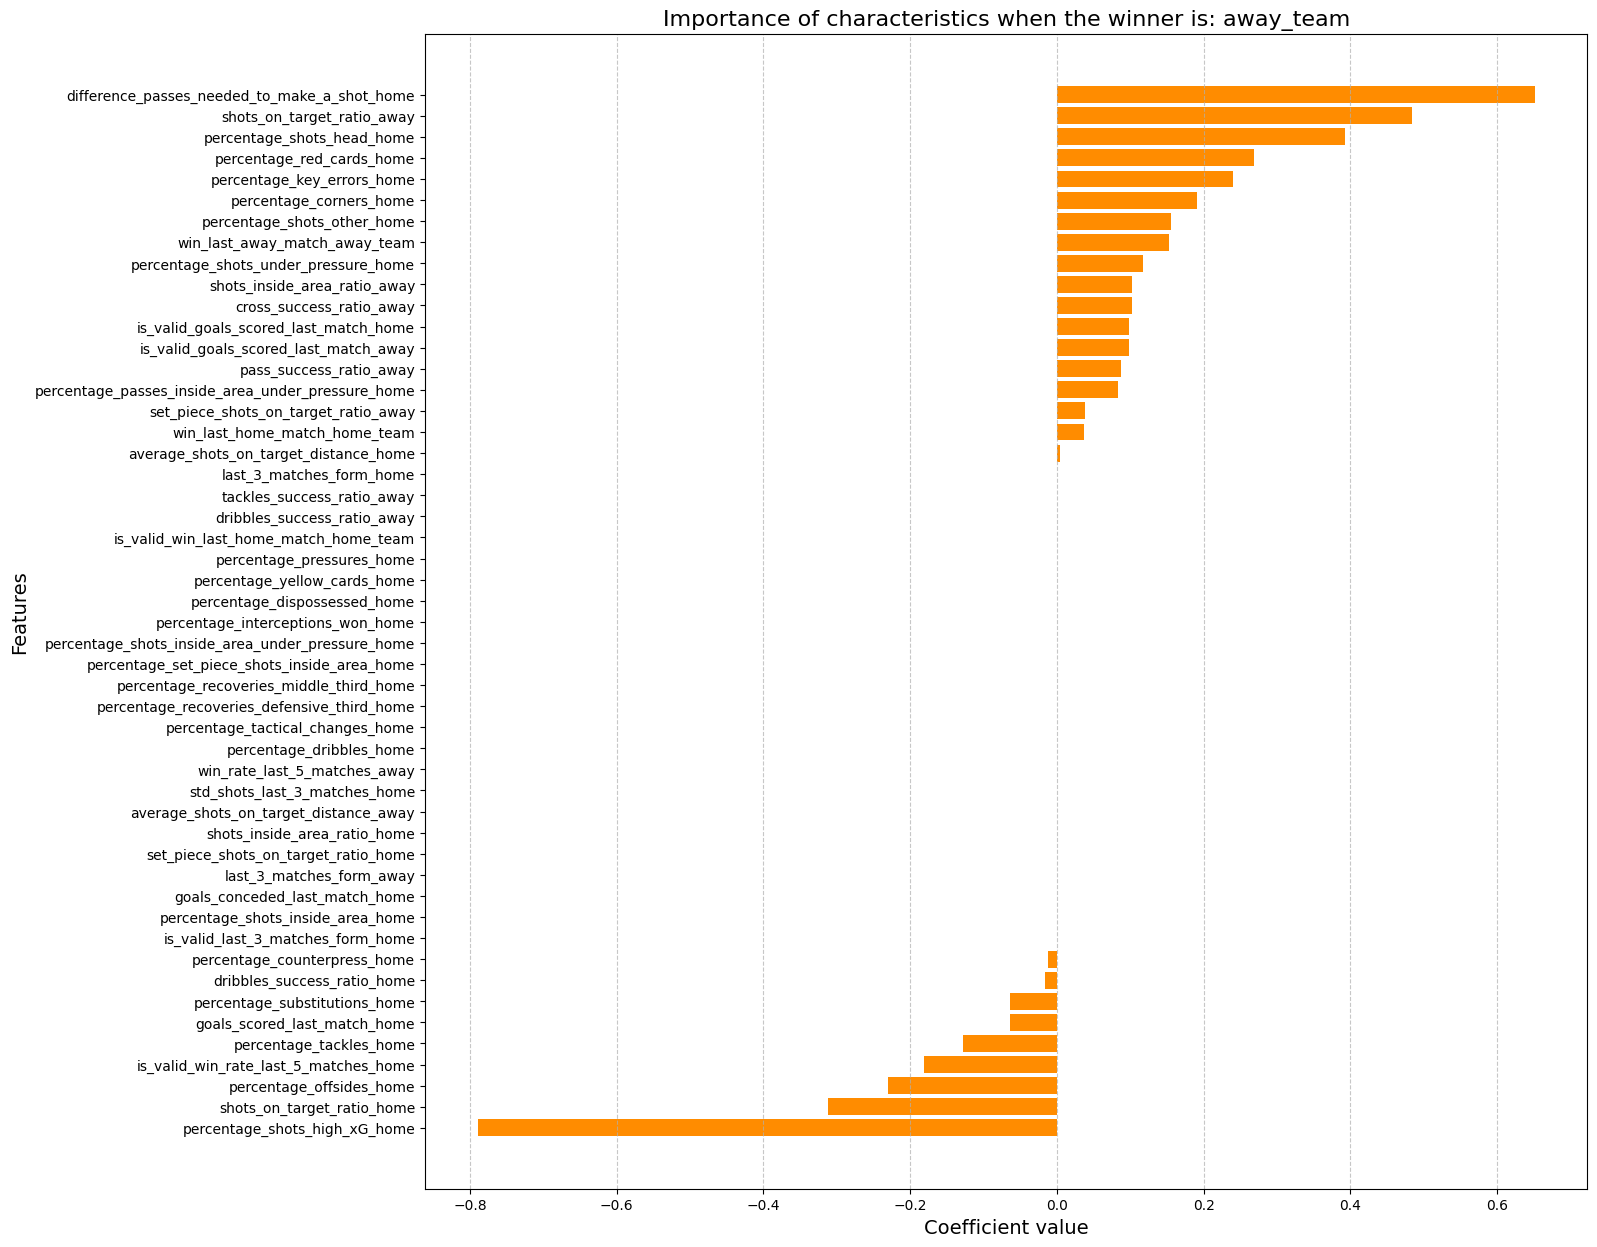

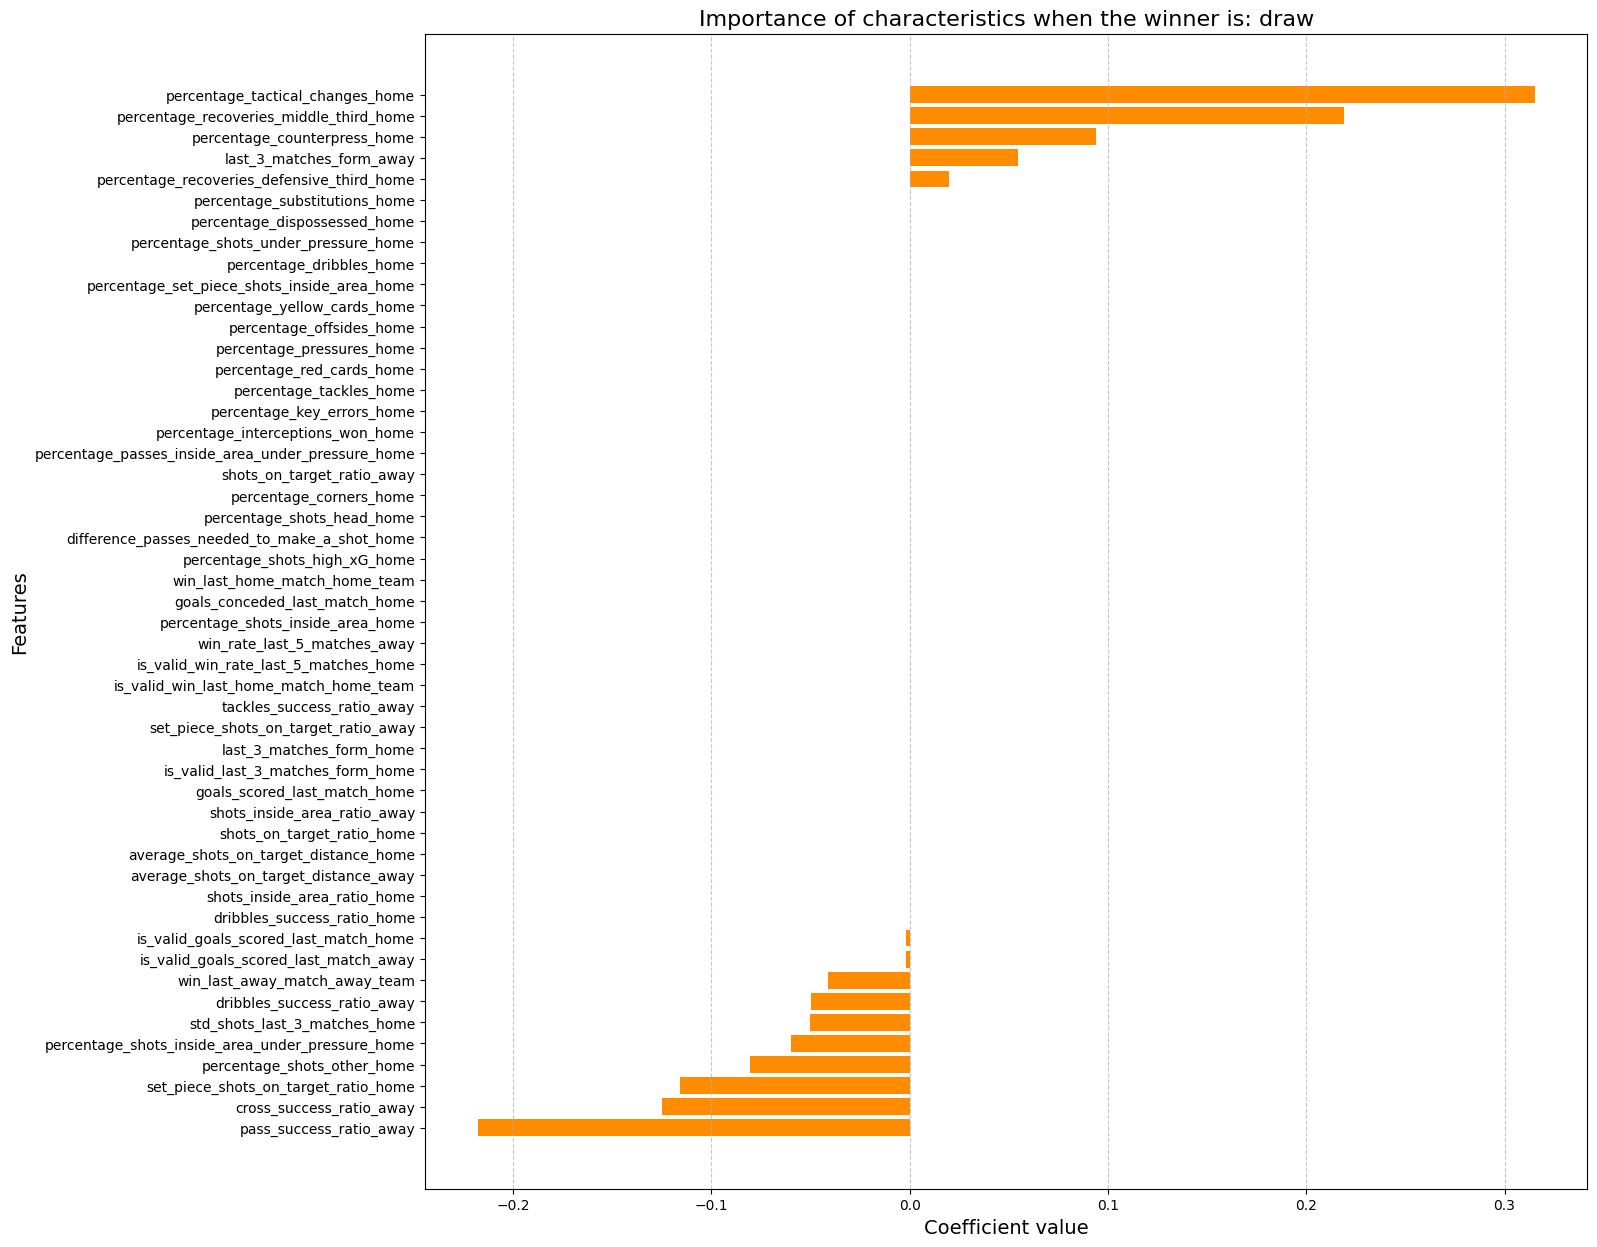

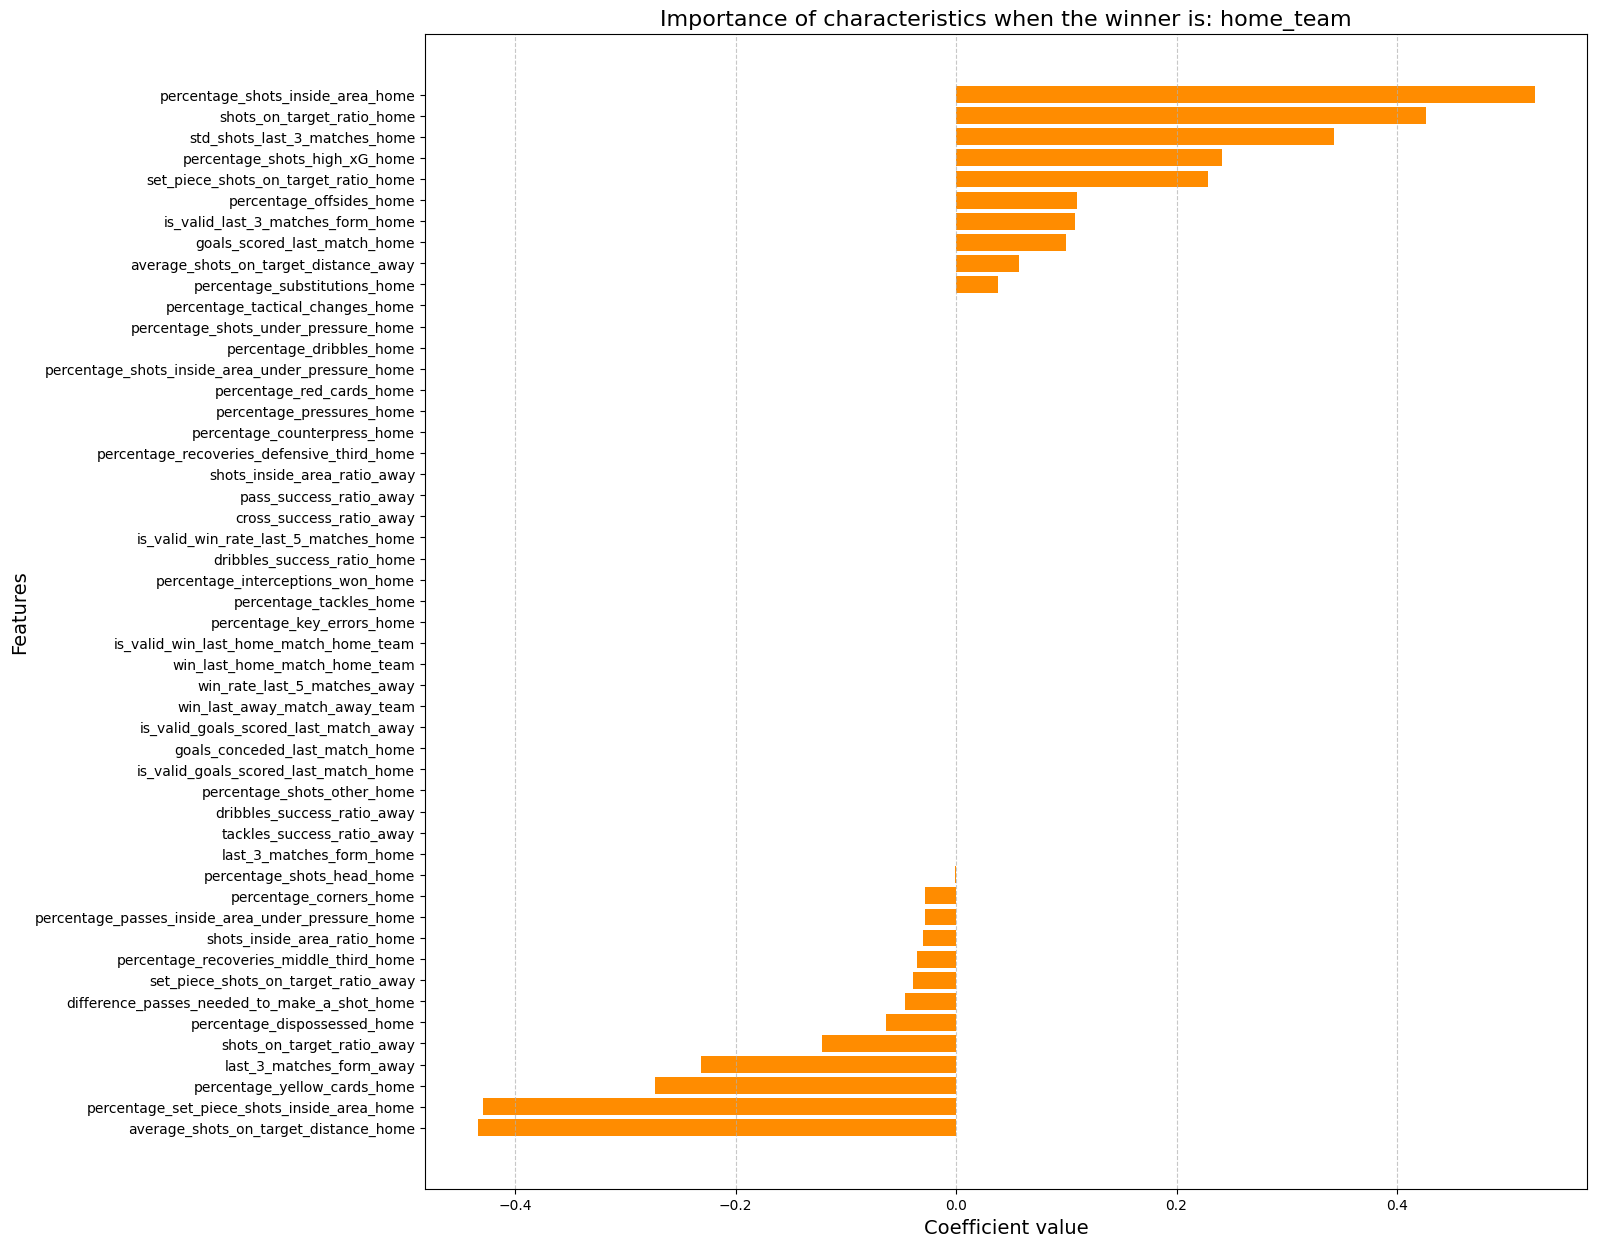

In [12]:
from src.analysis import laliga_global_analysis

laliga_global_analysis(best_model_LaLiga, feature_names_reduced_LaLiga, encoder_LaLiga)

Vamos a analizar cada uno de estos gráficos:
- **Importancia de características para la victoria del equipo visitante (*away_team*)**: En este gráfico, observamos las características que más influyen en que el equipo visitante gane el partido. Algunas observaciones clave:
    - 📈 Características que favorecen la victoria del equipo visitante (coeficientes positivos):
        - Diferencia de pases necesarios para hacer un gol (difference_passes_needed_to_make_a_shot_home): Si el equipo local necesita más pases para generar un gol, esto indica una menor eficiencia ofensiva, lo que favorece al equipo visitante.
        - Ratio de tiros a puerta del equipo visitante (shots_on_target_ratio_away): Cuanto mayor sea este valor, más eficiente es el equipo visitante al finalizar sus jugadas.
        - Tiros de cabeza del equipo visitante (shots_head_home): Si el equipo local intenta más tiros de cabeza, puede reflejar una dependencia de centros y juego aéreo, lo que podría ser una señal de que tienen menos oportunidades claras de gol.
    - 📉 Características que disminuyen la probabilidad de victoria del equipo visitante (coeficientes negativos):
        - Tiros de alto xG del equipo local (percentage_shots_high_xG_home): Si el equipo local genera más tiros de alto valor de gol esperado (xG), es más probable que marquen y ganen el partido.
        - Ratio de tiros a puerta del equipo local (shots_on_target_ratio_home): Un equipo local más preciso en sus disparos es menos propenso a perder.
        - Número de fueras de juego del equipo local (percentage_offsides_home): Puede indicar una estrategia ofensiva más agresiva, lo que reduce la posibilidad de que el equipo visitante gane.
    - 📝 Conclusión: Para que el equipo visitante gane, es crucial que finalicen mejor sus jugadas y que el equipo local tenga dificultades ofensivas, como necesitar más pases para generar un gol o depender de tiros de cabeza.

- **Importancia de características para el empate (*draw*)**: El empate en un partido suele estar influenciado por un equilibrio en las métricas de ataque y defensa de ambos equipos. Algunas observaciones clave:
    - 📈 Características que favorecen el empate (coeficientes positivos):
        - Cambios tácticos del equipo local (percentage_tactical_changes_home): Indica que el equipo local ajusta su estrategia durante el partido, lo que puede hacer que el juego sea más parejo y termine en empate.
        - Número de recuperaciones en el tercio medio del campo (percentage_recoveries_middle_third_home): Un alto número de recuperaciones en el mediocampo sugiere un partido con muchas disputas y menos oportunidades claras de gol.
        - Presión y contragolpe del equipo local (percentage_counterpress_home): Un equipo local que presiona mucho después de perder el balón puede neutralizar los ataques del visitante, resultando en un empate.
    - 📉 Características que reducen la probabilidad de empate (coeficientes negativos):
        - Precisión en los pases del equipo visitante (pass_success_ratio_away): Si el equipo visitante es preciso en sus pases, aumenta la probabilidad de que puedan generar más ocasiones de gol y ganar el partido.
        - Tiros dentro del área del equipo visitante (shots_inside_area_ratio_away): Cuantas más llegadas claras tenga el equipo visitante, menos probable es que el partido termine en empate.
        - Ratio de tiros a puerta del equipo visitante (shots_on_target_ratio_away): Una mayor eficiencia del visitante en tiros a puerta reduce la probabilidad de empate.
    - 📝 Conclusión: El empate suele ocurrir cuando ambos equipos tienen un estilo equilibrado, con una buena presión en el mediocampo y ajustes tácticos, pero sin una gran diferencia en precisión de pases o tiros dentro del área.

- **Importancia de características para la victoria del equipo local (*local_team*)**: Este gráfico muestra las características que aumentan o disminuyen la probabilidad de que el equipo local gane el partido. Algunas observaciones claves:
    - 📈 Características que favorecen la victoria del equipo local (coeficientes positivos):
        - Porcentaje de tiros dentro del área del equipo local (percentage_shots_inside_area_home): Los equipos locales que generan más tiros dentro del área tienen más probabilidades de marcar y ganar.
        - Ratio de tiros a puerta del equipo local (shots_on_target_ratio_home): Un equipo local más preciso en sus disparos tiene mayor probabilidad de victoria.
        - Número de tiros con alto xG del equipo local (shots_high_xG_home): Si el equipo local genera más tiros con alto valor de gol esperado (xG), es más probable que marquen y ganen el partido.
    - 📉 Características que disminuyen la probabilidad de victoria del equipo local (coeficientes negativos):
        - Diferencia de pases necesarios para hacer un gol (difference_passes_needed_to_make_a_shot_home): Si el equipo local necesita muchos pases para generar un gol, significa que su ofensiva es menos eficiente.
        - Precisión en los centros al área del equipo visitante (cross_success_ratio_away): Un equipo visitante que logre conectar bien sus centros tiene más probabilidades de generar peligro y evitar la victoria local.
        - Ratio de éxito en dribbles del equipo visitante (dribbles_success_ratio_away): Si el equipo visitante es hábil en el regate, puede desestabilizar la defensa local y reducir sus opciones de victoria.
    - 📝 Conclusión: Para que el equipo local gane, es clave que generen tiros dentro del área con buena precisión, mientras que la presencia de un equipo visitante con buena precisión en pases y regates reduce las probabilidades de victoria local. 

- **Conclusiones generales**: 
    - El equipo visitante gana cuando tiene alta precisión en sus tiros a puerta y el equipo local es ineficiente ofensivamente.
    - El empate ocurre en partidos con alta presión en el mediocampo y cambios tácticos, lo que equilibra el juego.
    - El equipo local gana cuando genera muchas oportunidades de gol dentro del área y tiene buena precisión en sus tiros.

Ahora comenzamos el análisis de explicabilidad utilizando SHAP.

In [13]:
explainer_LaLiga = shap.Explainer(best_model_LaLiga, X_train_reduced_LaLiga, feature_names=feature_names_reduced_LaLiga)
shap_values_LaLiga = explainer_LaLiga(X_test_reduced_LaLiga)

Clase 0: ['away_team']
Características importantes (27):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'shots_inside_area_ratio_away', 'pass_success_ratio_away', 'cross_success_ratio_away', 'dribbles_success_ratio_home', 'set_piece_shots_on_target_ratio_away', 'is_valid_win_rate_last_5_matches_home', 'win_last_home_match_home_team', 'win_last_away_match_away_team', 'goals_scored_last_match_home', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'percentage_shots_high_xG_home', 'percentage_shots_head_home', 'percentage_shots_other_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_tackles_home', 'percentage_key_errors_home', 'percentage_red_cards_home', 'percentage_counterpress_home', 'percentage_offsides_home', 'percentage_shots_under_pressure_home', 'percentage_passes_inside_area_under_pressure_home', 'percentage_substitutions_home']
Características SIN i

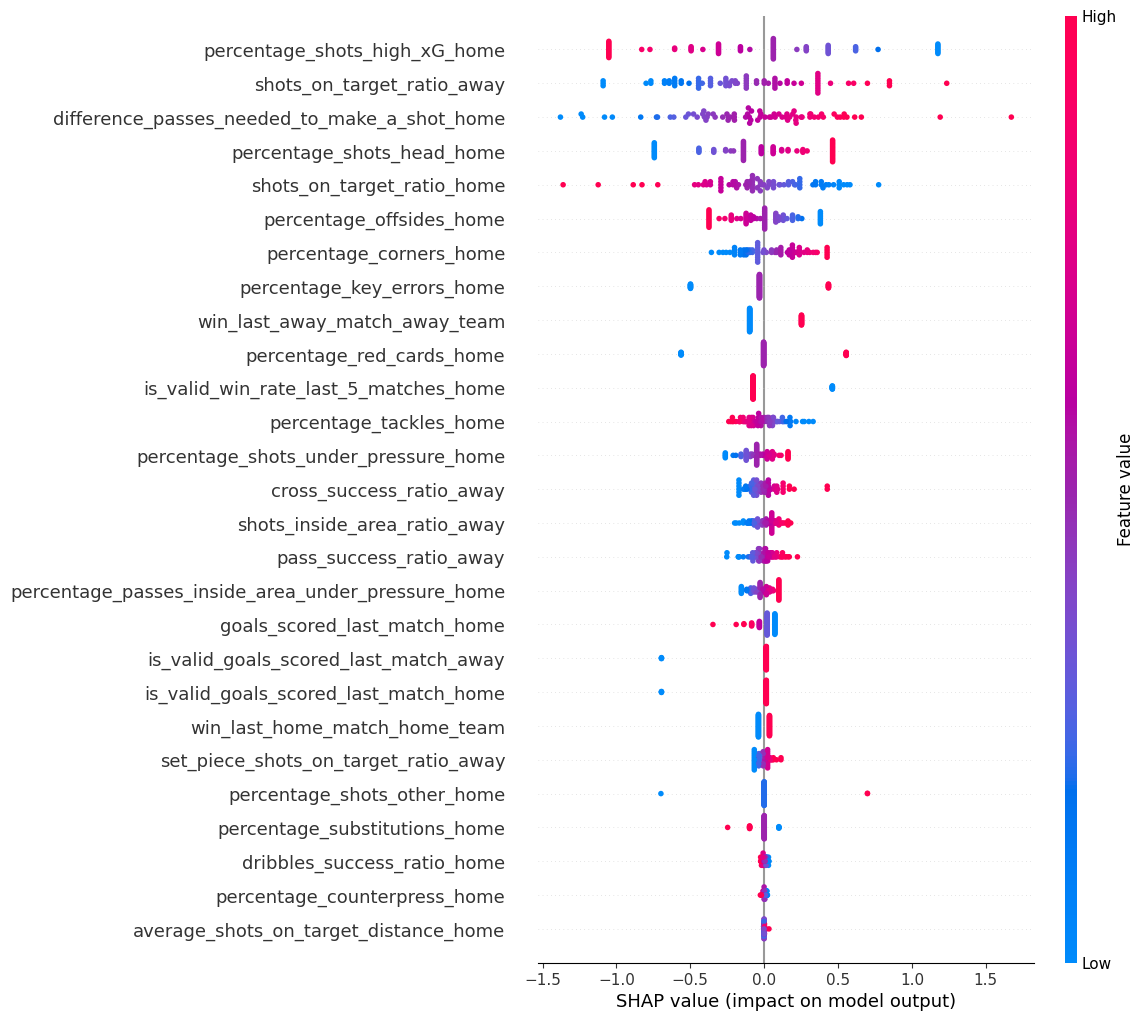

Clase 1: ['draw']
Características importantes (15):
['pass_success_ratio_away', 'cross_success_ratio_away', 'dribbles_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'last_3_matches_form_away', 'win_last_away_match_away_team', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'std_shots_last_3_matches_home', 'percentage_shots_other_home', 'percentage_counterpress_home', 'percentage_recoveries_middle_third_home', 'percentage_recoveries_defensive_third_home', 'percentage_shots_inside_area_under_pressure_home', 'percentage_tactical_changes_home']
Características SIN impacto (35):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'shots_inside_area_ratio_away', 'tackles_success_ratio_away', 'dribbles_success_ratio_home', 'set_piece_shots_on_target_ratio_away', 'last_3_matches_form_home', 'is_valid_last_3_matches_form_home'

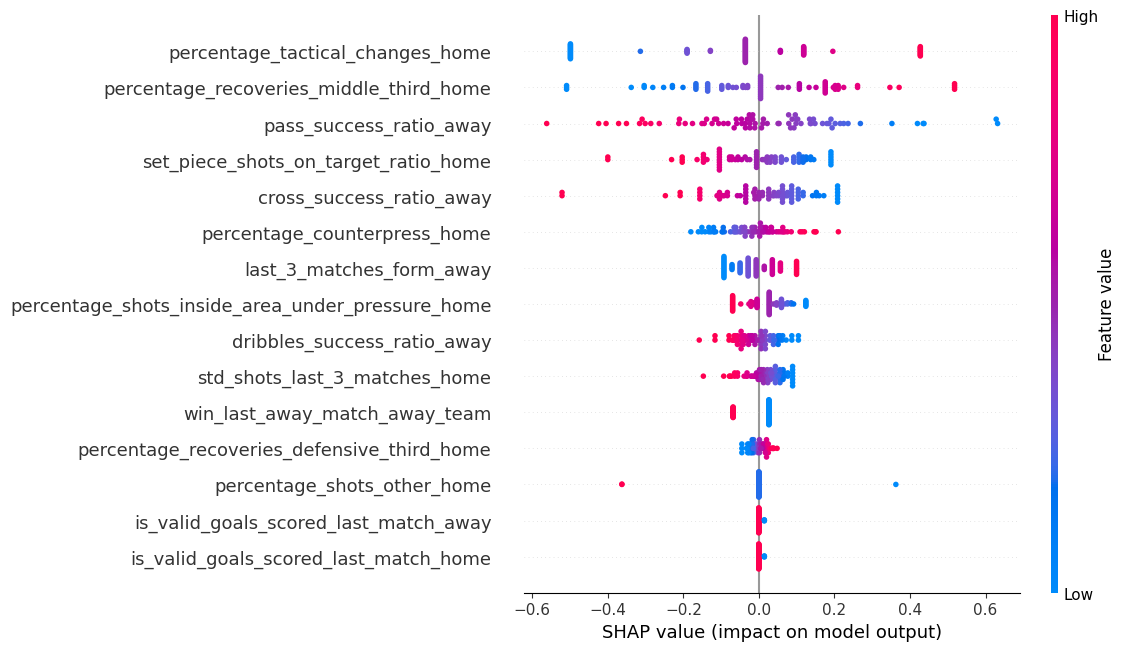

Clase 2: ['home_team']
Características importantes (23):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'set_piece_shots_on_target_ratio_home', 'set_piece_shots_on_target_ratio_away', 'is_valid_last_3_matches_form_home', 'last_3_matches_form_away', 'goals_scored_last_match_home', 'std_shots_last_3_matches_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'percentage_shots_head_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_corners_home', 'percentage_yellow_cards_home', 'percentage_offsides_home', 'percentage_dispossessed_home', 'percentage_recoveries_middle_third_home', 'percentage_passes_inside_area_under_pressure_home', 'percentage_set_piece_shots_inside_area_home', 'percentage_substitutions_home']
Características SIN impacto (27):
['shots_inside_area_ratio_away', 'pass_success_ratio_away', 'cross_success_ratio_

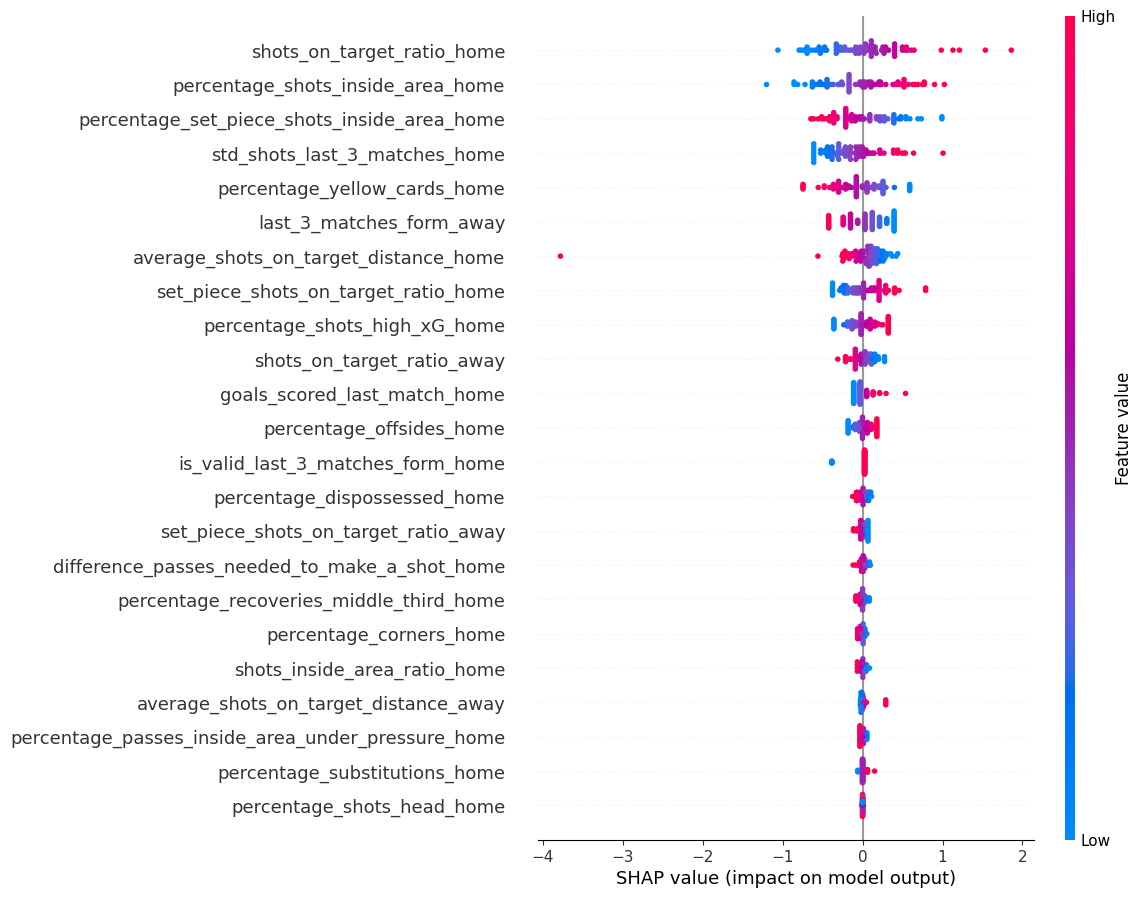

In [14]:
# definimos un umbral de importancia
threshold = 0.0

for i in range(shap_values_LaLiga.shape[2]):
    print(f"Clase {i}: {encoder_LaLiga.inverse_transform([i])}")
    # calculamos la importancia media de cada característica y filtramos las características que superen el umbral
    shap_importance = np.abs(shap_values_LaLiga.values[:, :, i]).mean(axis=0)
    important_features = np.where(shap_importance > threshold)[0]
    unimportant_features = np.where(shap_importance <= threshold)[0]
    print(f"Características importantes ({len(important_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in important_features])
    print(f"Características SIN impacto ({len(unimportant_features)}):")
    print([feature_names_reduced_LaLiga[idx] for idx in unimportant_features])
    # si hay características que superen el umbral, mostramos el gráfico
    if len(important_features) > 0:
        shap.plots.beeswarm(shap_values_LaLiga[:, important_features, i], max_display=important_features.size)
    else:
        print(f"No hay características con impacto mayor a {threshold} para la clase {i}.")